# Face Recognition using Principal Component Analysis

Recent advance in machine learning has made face recognition not a difficult problem. But in the previous, researchers have made various attempts and developed various skills to make computer capable of identifying people. One of the early attempt with moderate success is eigenface, which is based on linear algebra techniques.

In this tutorial, we will see how we can build a primitive face recognition system with some simple linear algebra technique such as principal component analysis.

After completing this tutorial, you will know:

* The development of eigenface technique
* How to use principal component analysis to extract characteristic images from an image dataset
* How to express any image as a weighted sum of the characteristic images
* How to compare the similarity of images from the weight of principal components

Let’s get started.

![image](https://machinelearningmastery.com/wp-content/uploads/2021/10/rach-teo-2BzUlVUWCoo-unsplash-1.jpg)


# Tutorial overview

This tutorial is divided into 3 parts; they are:

* Image and Face Recognition
* Overview of Eigenface
* Implementing Eigenface

# Image and Face Recognition

In computer, pictures are represented as a matrix of pixels, with each pixel a particular color coded in some numerical values. It is natural to ask if computer can read the picture and understand what it is, and if so, whether we can describe the logic using matrix mathematics. To be less ambitious, people try to limit the scope of this problem to identifying human faces. An early attempt for face recognition is to consider the matrix as a high dimensional detail and we infer a lower dimension information vector from it, then try to recognize the person in lower dimension. It was necessary in the old time because the computer was not powerful and the amount of memory is very limited. However, by exploring how to **compress** image to a much smaller size, we developed a skill to compare if two images are portraying the same human face even if the pictures are not identical.

In 1987, a paper by Sirovich and Kirby considered the idea that all pictures of human face to be a weighted sum of a few “key pictures”. Sirovich and Kirby called these key pictures the “eigenpictures”, as they are the eigenvalues of the covariance matrix of the mean-subtracted pictures of human faces. In the paper they indeed provided the algorithm of principal component analysis of the face picture dataset in its matrix form. And the weights used in the weighted sum indeed correspond to the projection of the face picture into each eigenpicture.

In 1991, a paper by Turk and Pentland coined the term “eigenface”. They built on top of the idea of Sirovich and Kirby and use the weights and eigenpictures as characteristic features to recognize faces. The paper by Turk and Pentland laid out a memory-efficient way to compute the eigenpictures. It also proposed an algorithm on how the face recognition system can operate, including how to update the system to include new faces and how to combine it with a video capture system. The same paper also pointed out that the concept of eigenface can help reconstruction of partially obstructed picture.

# Overview of Eigenface

Before we jump into the code, let’s outline the steps in using eigenface for face recognition, and point out how some simple linear algebra technique can help the task.

Assume we have a bunch of pictures of human faces, all in the same pixel dimension (e.g., all are r×c grayscale images). If we get M different pictures and **vectorize** each picture into L=r×c pixels, we can present the entire dataset as a L×M matrix (let’s call it matrix $A$), where each element in the matrix is the pixel’s grayscale value.

Recall that principal component analysis (PCA) can be applied to any matrix, and the result is a number of vectors called the **principal components**. Each principal component has the length same as the column length of the matrix. The different principal components from the same matrix are orthogonal to each other, meaning that the vector dot-product of any two of them is zero. Therefore the various principal components constructed a vector space for which each column in the matrix can be represented as a linear combination (i.e., weighted sum) of the principal components. 

The way it is done is to first take $C = A-a$ where $a$ is the mean vector of the matrix $A$. So $C$ is the matrix that subtract each column of $A$ with the mean vector 
$a$. Then the covariance matrix is 
\begin{equation}
S= C \cdot C^T
\end{equation}
from which we find its eigenvectors and eigenvalues. The principal components are these eigenvectors in decreasing order of the eigenvalues. Because matrix 
$S$ is a L×L matrix, we may consider to find the eigenvectors of a M×M matrix 
$C^T \cdot C$ instead as the eigenvector $v$ for $C^T \cdot C$ can be transformed into eigenvector $u$ of $C^T \cdot C$ by $U=C \cdot v$, except we usually prefer to write 
$u$ as normalized vector (i.e., norm of $u$ is 1).

The physical meaning of the principal component vectors of $A$, or equivalently the eigenvectors of $S=C \cdot C^T$, is that they are the key directions that we can construct the columns of matrix $A$. The relative importance of the different principal component vectors can be inferred from the corresponding eigenvalues. The greater the eigenvalue, the more useful (i.e., holds more information about $A$) the principal component vector. Hence we can keep only the first K principal component vectors. If matrix A is the dataset for face pictures, the first K principal component vectors are the top K most important “face pictures”. We call them the eigenface picture.

For any given face picture, we can project its mean-subtracted version onto the eigenface picture using vector dot-product. The result is how close this face picture is related to the eigenface. If the face picture is totally unrelated to the eigenface, we would expect its result is zero. For the K eigenfaces, we can find K dot-product for any given face picture. We can present the result as **weights** of this face picture with respect to the eigenfaces. The weight is usually presented as a vector.

Conversely, if we have a weight vector, we can add up each eigenfaces subjected to the weight and reconstruct a new face. Let’s denote the eigenfaces as matrix $F$, which is a L×K matrix, and the weight vector $w$ is a column vector. Then for any $w$ we can construct the picture of a face as
\begin{equation}
z = F \cdot w
\end{equation}
which $z$ is resulted as a column vector of length L. Because we are only using the top K principal component vectors, we should expect the resulting face picture is distorted but retained some facial characteristic.

Since the eigenface matrix is constant for the dataset, a varying weight vector $w$ means a varying face picture. Therefore we can expect the pictures of the same person would provide similar weight vectors, even if the pictures are not identical. As a result, we may make use of the distance between two weight vectors (such as the L2-norm) as a metric of how two pictures resemble.

# Implementing Eigenface

Now we attempt to implement the idea of eigenface with numpy and scikit-learn. We will also make use of OpenCV to read picture files. You may need to install the relevant package with pip command:

```shell
pip install opencv-python
```

The dataset we use are the ORL Database of Faces, which is quite of age but we can download it from Kaggle:

* https://www.kaggle.com/kasikrit/att-database-of-faces/download

The file is a zip file of around 4MB. It has pictures of 40 persons and each person has 10 pictures. Total to 400 pictures. In the following we assumed the file is downloaded to the local directory and named as `attface.zip`.

We may extract the zip file to get the pictures, or we can also make use of the zipfile package in Python to read the contents from the zip file directly:

In [2]:
import cv2
import zipfile
import numpy as np

faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

In [4]:
print(len(faces))
print(faces)

400
{'s1/1.pgm': array([[48, 49, 45, ..., 56, 56, 54],
       [45, 52, 39, ..., 52, 50, 51],
       [45, 50, 42, ..., 48, 53, 50],
       ...,
       [50, 48, 50, ..., 45, 46, 46],
       [45, 54, 49, ..., 46, 47, 47],
       [51, 51, 51, ..., 47, 46, 46]], dtype=uint8), 's1/10.pgm': array([[34, 34, 33, ...,  1,  1,  1],
       [35, 30, 32, ..., 38, 47, 39],
       [34, 28, 31, ..., 55, 59, 49],
       ...,
       [30, 29, 31, ..., 35, 37, 41],
       [31, 29, 32, ..., 42, 34, 39],
       [28, 33, 27, ..., 37, 40, 33]], dtype=uint8), 's1/2.pgm': array([[ 60,  60,  62, ...,  40,  53,  46],
       [ 58,  73,  54, ...,  34,  50,  51],
       [ 68,  77,  80, ...,  36,  50,  49],
       ...,
       [ 24, 143, 160, ...,  34,  33,  33],
       [ 18, 136, 161, ...,  36,  36,  31],
       [  9, 111, 168, ...,  32,  34,  34]], dtype=uint8), 's1/3.pgm': array([[39, 44, 53, ..., 47, 48, 47],
       [44, 44, 61, ..., 47, 45, 46],
       [59, 39, 57, ..., 46, 46, 44],
       ...,
       [49, 46, 42,

The above is to read every PGM file in the zip. PGM is a grayscale image file format. We extract each PGM file into a byte string through image.read() and convert it into a numpy array of bytes. Then we use OpenCV to decode the byte string into an array of pixels using cv2.imdecode(). The file format will be detected automatically by OpenCV. We save each picture into a Python dictionary faces for later use.

Here we can take a look on these picture of human faces, using matplotlib:

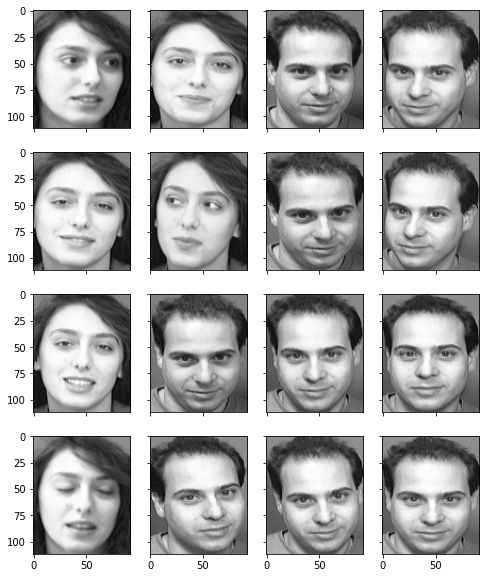

In [5]:
...
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

We can also find the pixel size of each picture:

In [6]:
...
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (112, 92)


The pictures of faces are identified by their file name in the Python dictionary. We can take a peek on the filenames:

In [7]:
...
print(list(faces.keys())[:5])

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']


and therefore we can put faces of the same person into the same class. There are 40 classes and totally 400 pictures:

In [8]:
...
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of pictures:", len(faces))

Number of classes: 40
Number of pictures: 400


To illustrate the capability of using eigenface for recognition, we want to hold out some of the pictures before we generate our eigenfaces. We hold out all the pictures of one person as well as one picture for another person as our test set. The remaining pictures are vectorized and converted into a 2D numpy array:

In [9]:
...
# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

# Create facematrix as (n_samples,n_pixels) matrix
facematrix = np.array(facematrix)

Now we can perform principal component analysis on this dataset matrix. Instead of computing the PCA step by step, we make use of the PCA function in scikit-learn, which we can easily retrieve all results we needed:

In [10]:
...
# Apply PCA to extract eigenfaces
from sklearn.decomposition import PCA

pca = PCA().fit(facematrix)

We can identify how significant is each principal component from the explained variance ratio:

In [11]:
...
print(pca.explained_variance_ratio_)

[1.77824822e-01 1.29057925e-01 6.67093882e-02 5.63561346e-02
 5.13040312e-02 3.39156477e-02 2.47893586e-02 2.27967054e-02
 1.95632067e-02 1.82678428e-02 1.45655853e-02 1.38626271e-02
 1.13318896e-02 1.07267786e-02 9.68365599e-03 9.17860717e-03
 8.60995215e-03 8.21053028e-03 7.36580634e-03 7.01112888e-03
 6.69450840e-03 6.40327943e-03 5.98295099e-03 5.49298705e-03
 5.36083980e-03 4.99408106e-03 4.84854321e-03 4.77687371e-03
 4.50099203e-03 4.35061143e-03 4.27684434e-03 4.05463914e-03
 3.96785012e-03 3.83241704e-03 3.69966355e-03 3.56356652e-03
 3.41269732e-03 3.33215240e-03 3.17642634e-03 3.03400142e-03
 2.97464206e-03 2.91054493e-03 2.86082016e-03 2.78052126e-03
 2.69873388e-03 2.60122139e-03 2.56106677e-03 2.50435737e-03
 2.44154438e-03 2.35425118e-03 2.31772334e-03 2.20335201e-03
 2.18249599e-03 2.16369451e-03 2.11113501e-03 2.05410950e-03
 2.00521036e-03 1.97423272e-03 1.95619744e-03 1.92361114e-03
 1.88146543e-03 1.81655157e-03 1.74212750e-03 1.70581678e-03
 1.66405571e-03 1.635671

or we can simply make up a moderate number, say, 50, and consider these many principal component vectors as the eigenface. For convenience, we extract the eigenface from PCA result and store it as a numpy array. Note that the eigenfaces are stored as rows in a matrix. We can convert it back to 2D if we want to display it. In below, we show some of the eigenfaces to see how they look like:

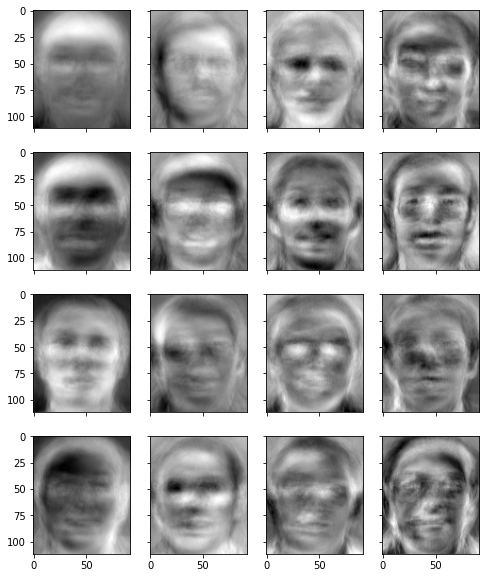

In [12]:
...
# Take the first K principal components as eigenfaces
n_components = 50
eigenfaces = pca.components_[:n_components]

# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
plt.show()

From this picture, we can see eigenfaces are blurry faces, but indeed each eigenfaces holds some facial characteristics that can be used to build a picture.

Since our goal is to build a face recognition system, we first calculate the weight vector for each input picture:

In [19]:
...
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T

The above code is using matrix multiplication to replace loops. It is roughly equivalent to the following:

In [14]:
...
weights = []
for i in range(facematrix.shape[0]):
    weight = []
    for j in range(n_components):
        w = eigenfaces[j] @ (facematrix[i] - pca.mean_)
        weight.append(w)
    weights.append(weight)

Up to here, our face recognition system has been completed. We used pictures of 39 persons to build our eigenface. We use the test picture that belongs to one of these 39 persons (the one held out from the matrix that trained the PCA model) to see if it can successfully recognize the face:

Best match s39 with Euclidean distance 1559.997137


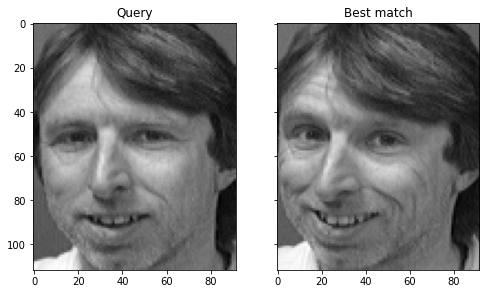

In [20]:
...
# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Above, we first subtract the vectorized image by the average vector that retrieved from the PCA result. Then we compute the projection of this mean-subtracted vector to each eigenface and take it as the weight for this picture. Afterwards, we compare the weight vector of the picture in question to that of each existing picture and find the one with the smallest L2 distance as the best match. We can see that it indeed can successfully find the closest match in the same class:

We can try again with the picture of the 40th person that we held out from the PCA. We would never get it correct because it is a new person to our model. However, we want to see how wrong it can be as well as the value in the  distance metric:

Best match s5 with Euclidean distance 2690.209330


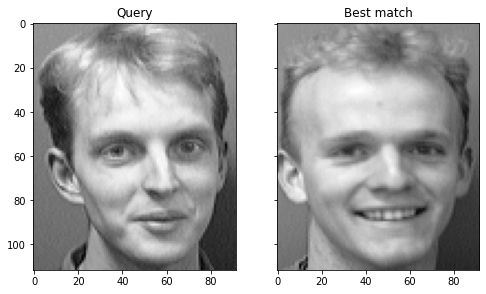

In [21]:
...
# Test on out-of-sample image of new class
query = faces["s40/1.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

In the paper by Turk and Petland, it is suggested that we set up a threshold for the L2 distance. If the best match’s distance is less than the threshold, we would consider the face is recognized to be the same person. If the distance is above the threshold, we claim the picture is someone we never saw even if a best match can be find numerically. In this case, we may consider to include this as a new person into our model by remembering this new weight vector.

Actually, we can do one step further, to generate new faces using eigenfaces, but the result is not very realistic. In below, we generate one using random weight vector and show it side by side with the “average face”:

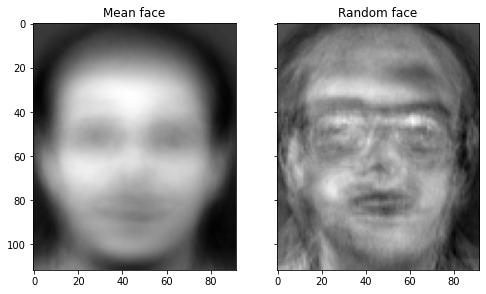

In [22]:
...
# Visualize the mean face and random face
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(pca.mean_.reshape(faceshape), cmap="gray")
axes[0].set_title("Mean face")
random_weights = np.random.randn(n_components) * weights.std()
newface = random_weights @ eigenfaces + pca.mean_
axes[1].imshow(newface.reshape(faceshape), cmap="gray")
axes[1].set_title("Random face")
plt.show()

How good is eigenface? It is surprisingly overachieved for the simplicity of the model. However, Turk and Pentland tested it with various conditions. It found that its accuracy was “an average of 96% with light variation, 85% with orientation variation, and 64% with size variation.” Hence it may not be very practical as a face recognition system. After all, the picture as a matrix will be distorted a lot in the principal component domain after zoom-in and zoom-out. Therefore the modern alternative is to use convolution neural network, which is more tolerant to various transformations.

Putting everything together, the following is the complete code:

Showing sample faces


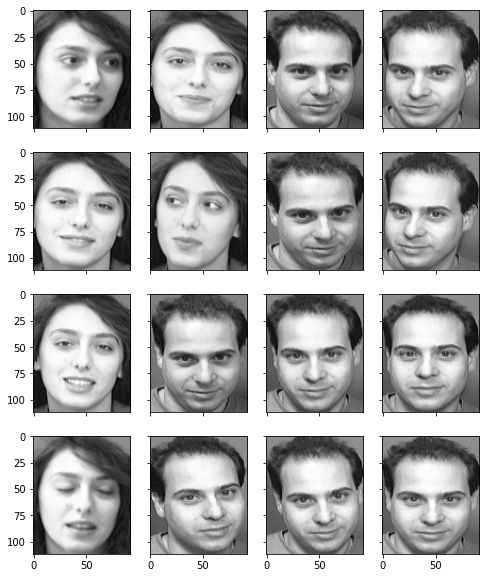

Face image shape: (112, 92)
Number of classes: 40
Number of images: 400
Showing the eigenfaces


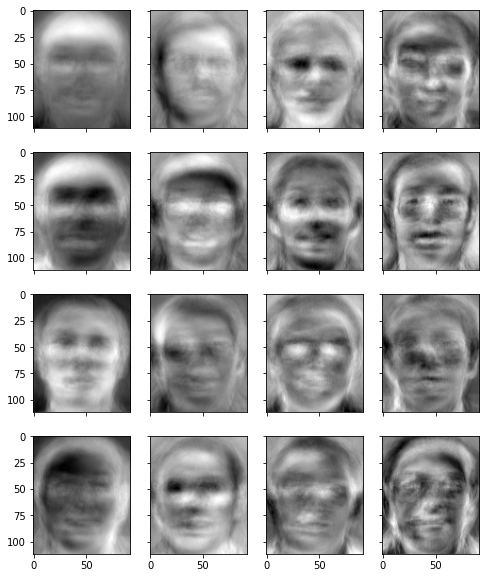

Shape of the weight matrix: (50, 389)
Best match s39 with Euclidean distance 1559.997137


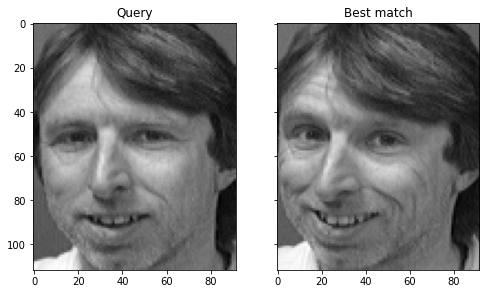

Best match s5 with Euclidean distance 2690.209330


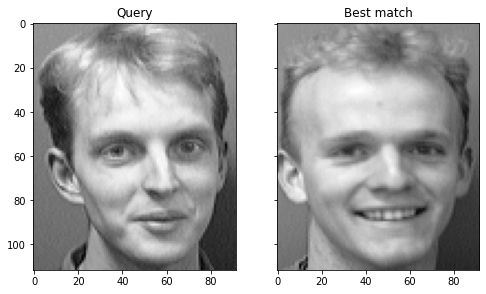

In [18]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Read face image from zip file on the fly
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

# Show sample faces using matplotlib
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

# Print some details
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

# Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)

# Apply PCA and take first K principal components as eigenfaces
pca = PCA().fit(facematrix)

n_components = 50
eigenfaces = pca.components_[:n_components]

# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the eigenfaces")
plt.show()

# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

# Test on out-of-sample image of new class
query = faces["s40/1.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

# Further reading

This section provides more resources on the topic if you are looking to go deeper.

# Papers
* L. Sirovich and M. Kirby (1987). ["Low-dimensional procedure for the characterization of human faces“](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces). Journal of the Optical Society of America A. 4(3): 519–524.
* M. Turk and A. Pentland (1991). [“Eigenfaces for recognition“](https://www.cs.ucsb.edu/~mturk/Papers/jcn.pdf). Journal of Cognitive Neuroscience. 3(1): 71–86.

# Books
* [Introduction to Linear Algebra](https://amzn.to/2CZgTTB), Fifth Edition, 2016.

# APIs
* [sklearn.decomposition.PCA API](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [matplotlib.pyplot.imshow API](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)

# Articles
* [Eigenface on Wikipedia](https://en.wikipedia.org/wiki/Eigenface)

# Summary

In this tutorial, you discovered how to build a face recognition system using eigenface, which is derived from principal component analysis.

Specifically, you learned:

* How to extract characteristic images from the image dataset using principal component analysis
* How to use the set of characteristic images to create a weight vector for any seen or unseen images
* How to use the weight vectors of different images to measure for their similarity, and apply this technique to face recognition
* How to generate a new random image from the characteristic images

# Tutorial Overview

This tutorial is divided into 3 parts; they are:

1. Principal Component Analysis
2. Manually Calculate Principal Component Analysis
3. Reusable Principal Component Analysis

# Principal Component Analysis

Principal Component Analysis, or PCA for short, is a method for reducing the dimensionality of data.

It can be thought of as a projection method where data with m-columns (features) is projected into a subspace with m or fewer columns, whilst retaining the essence of the original data.

The PCA method can be described and implemented using the tools of linear algebra.

PCA is an operation applied to a dataset, represented by an n x m matrix A that results in a projection of A which we will call B. Let’s walk through the steps of this operation.

The first step is to calculate the mean values of each column.

or

Next, we need to center the values in each column by subtracting the mean column value.

The next step is to calculate the covariance matrix of the centered matrix C.

Correlation is a normalized measure of the amount and direction (positive or negative) that two columns change together. Covariance is a generalized and unnormalized version of correlation across multiple columns. A covariance matrix is a calculation of covariance of a given matrix with covariance scores for every column with every other column, including itself.

Finally, we calculate the [eigendecomposition](https://machinelearningmastery.com/introduction-to-eigendecomposition-eigenvalues-and-eigenvectors/) of the covariance matrix V. This results in a list of eigenvalues and a list of eigenvectors.

The eigenvectors represent the directions or components for the reduced subspace of B, whereas the eigenvalues represent the magnitudes for the directions. For more on this topic, see the post:
* [Gentle Introduction to Eigendecomposition, Eigenvalues, and Eigenvectors for Machine Learning](https://machinelearningmastery.com/introduction-to-eigendecomposition-eigenvalues-and-eigenvectors/)

The eigenvectors can be sorted by the eigenvalues in descending order to provide a ranking of the components or axes of the new subspace for A.

If all eigenvalues have a similar value, then we know that the existing representation may already be reasonably compressed or dense and that the projection may offer little. If there are eigenvalues close to zero, they represent components or axes of B that may be discarded.

A total of m or less components must be selected to comprise the chosen subspace. Ideally, we would select k eigenvectors, called principal components, that have the k largest eigenvalues.

Other matrix decomposition methods can be used such as [Singular-Value Decomposition](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/), or SVD. As such, generally the values are referred to as singular values and the vectors of the subspace are referred to as principal components.

Once chosen, data can be projected into the subspace via matrix multiplication.

Where A is the original data that we wish to project, B^T is the transpose of the chosen principal components and P is the projection of A.

This is called the covariance method for calculating the PCA, although there are alternative ways to to calculate it.

# Manually Calculate Principal Component Analysis

There is no `pca()` function in NumPy, but we can easily calculate the Principal Component Analysis step-by-step using NumPy functions.

The example below defines a small 3×2 matrix, centers the data in the matrix, calculates the covariance matrix of the centered data, and then the eigendecomposition of the covariance matrix. The eigenvectors and eigenvalues are taken as the principal components and singular values and used to project the original data.

In [41]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
print('Array A = \n{}'.format(A))

# calculate the mean of each column
M = mean(A.T, axis=1)
print('\nArray M = mean(A.T) =\n {}'.format(M))

# center columns by subtracting column means
C = A - M
print('\nArray C = = A - M =\n {}'.format(C))

# calculate covariance matrix of centered matrix
V = cov(C.T)
print('\nArray V = = cov(C.T) =\n {}\n'.format(V))

# eigendecomposition of covariance matrix
values, vectors = eig(V)
print('\nValues =\n {}'.format(values))
print('\nVectors =\n {}'.format(vectors))

# project data
P = vectors.T.dot(C.T)
print('\n Proyection =\n {}'.format(P.T))

Array A = 
[[1 2]
 [3 4]
 [5 6]]

Array M = mean(A.T) =
 [3. 4.]

Array C = = A - M =
 [[-2. -2.]
 [ 0.  0.]
 [ 2.  2.]]

Array V = = cov(C.T) =
 [[4. 4.]
 [4. 4.]]


Values =
 [8. 0.]

Vectors =
 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

 Proyection =
 [[-2.82842712  0.        ]
 [ 0.          0.        ]
 [ 2.82842712  0.        ]]


# Reusable Principal Component Analysis

We can calculate a Principal Component Analysis on a dataset using the PCA() class in the scikit-learn library. The benefit of this approach is that once the projection is calculated, it can be applied to new data again and again quite easily.

When creating the class, the number of components can be specified as a parameter.

The class is first fit on a dataset by calling the fit() function, and then the original dataset or other data can be projected into a subspace with the chosen number of dimensions by calling the transform() function.

Once fit, the eigenvalues and principal components can be accessed on the PCA class via the `explained_variance_` and `components_ attributes`.

The example below demonstrates using this class by first creating an instance, fitting it on a 3×2 matrix, accessing the values and vectors of the projection, and transforming the original data.

In [44]:
# Principal Component Analysis
from numpy import array
from sklearn.decomposition import PCA
# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
print('Array A = \n{}'.format(A))

# create the PCA instance
pca = PCA(2)
# fit on data
pca.fit(A)
# access values and vectors
print('\nValues =\n {}'.format(pca.explained_variance_))
print('\nVectors =\n {}'.format(pca.components_))

# transform data
B = pca.transform(A)
print('\n Proyection =\n {}'.format(B))

Array A = 
[[1 2]
 [3 4]
 [5 6]]

Values =
 [8. 0.]

Vectors =
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

 Proyection =
 [[-2.82842712e+00 -2.22044605e-16]
 [ 0.00000000e+00  0.00000000e+00]
 [ 2.82842712e+00  2.22044605e-16]]


Running the example first prints the 3×2 data matrix, then the principal components and values, followed by the projection of the original matrix.

We can see, that with some very minor floating point rounding that we achieve the same principal components, singular values, and projection as in the previous example.

# Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* Re-run the examples with your own small contrived matrix values.
* Load a dataset and calculate the PCA on it and compare the results from the two methods.
* Search for and locate 10 examples where PCA has been used in machine learning papers.

If you explore any of these extensions, I’d love to know.

# Further Reading

This section provides more resources on the topic if you are looking to go deeper.

# Books
* Section 7.3 Principal Component Analysis (PCA by the SVD), [Introduction to Linear Algebra](https://amzn.to/2CZgTTB), Fifth Edition, 2016.
* Section 2.12 Example: Principal Components Analysis, [Deep Learning](https://amzn.to/2B3MsuU), 2016.

# API
* [numpy.mean() API](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mean.html)
* [numpy.cov() API](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.cov.html)
* [numpy.linalg.eig() API](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.eig.html)
* [sklearn.decomposition.PCA API](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

# Articles
* [Principal component analysis on Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)
* [Covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix)

# Tutorials
* [Principal Component Analysis with numpy](https://glowingpython.blogspot.com.au/2011/07/principal-component-analysis-with-numpy.html), 2011.
* [PCA and image compression with numpy](https://glowingpython.blogspot.com.au/2011/07/pca-and-image-compression-with-numpy.html), 2011.
* [Implementing a Principal Component Analysis](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html) (PCA), 2014.

# Summary

In this tutorial, you discovered the Principal Component Analysis machine learning method for dimensionality reduction.

Specifically, you learned:

The procedure for calculating the Principal Component Analysis and how to choose principal components.
How to calculate the Principal Component Analysis from scratch in NumPy.
How to calculate the Principal Component Analysis for reuse on more data in scikit-learn.
Do you have any questions?
Ask your questions in the comments below and I will do my best to answer.